In [1]:
%pip install pandas
%pip install pydmd
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn
%pip install keras_tuner
%pip install keras
%pip install numpy
%pip install optuna

/bin/bash: /home/yurid/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.
/bin/bash: /home/yurid/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.
/bin/bash: /home/yurid/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.
/bin/bash: /home/yurid/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.
/bin/bash: /home/yurid/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.
/bin/bash: /home/yurid/miniconda3/envs/tf/lib/libtinfo.so.6: no version informat

In [2]:
import sys, platform

base_path = '/home/yurid/git/tcc'

if platform.system() == 'Darwin':
    base_path = '/Users/yuri/git/diasYuri/tcc/radiation-forecast-mg'
    
sys.path.insert(0, base_path)

In [3]:
from math import sqrt

import keras
import numpy as np
import pandas as pd
import optuna
from keras import layers
from keras.callbacks import EarlyStopping
from keras_tuner.tuners import RandomSearch
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, InputLayer
from keras.callbacks import EarlyStopping
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame

2023-09-29 18:13:33.193020: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-29 18:13:35.392644: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/yurid/miniconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
city = 'vicosa'

In [5]:

def windowing(dataframe, predict_column, step_back, step_front) -> (np.array, np.array):
    dataset = dataframe.values
    dataset_pred = dataframe[predict_column].values

    x, y = [], []
    for i in range(len(dataset) - step_back - step_front):
        j = (i + step_back)
        x.append(dataset[i:j])
        y.append(dataset_pred[j:(j+step_front)])

    return np.array(x), np.array(y)



def split_data(x, y, length, ratio=0.8):
    train_size = int(length * 0.9)
    _train_x, _train_y = x[0:train_size], y[0:train_size].reshape(y[0:train_size].shape[0],)
    _test_x, _test_y = x[train_size:], y[train_size:].reshape(y[train_size:].shape[0],)
    return _train_x, _train_y, _test_x, _test_y


def fill_df(dataframe, filler):
    data = {}
    for column in dataframe.columns:
        data[column] = filler(dataframe[column])
    return pd.DataFrame(data=data, index=dataframe.index.values)


def interpolate_filler(data):
    return data.interpolate(method='linear', limit_direction='backward')


class Scaler:
    scales: {}
    df: DataFrame
    df_scaled: DataFrame
    scaled: bool

    def __init__(self, df: DataFrame, feature_range=(0, 1)):
        self.df = df.copy()
        self.scales = {}
        for c in df.columns:
            self.scales[c] = MinMaxScaler(feature_range=feature_range)
        self.scaled = False

    def get_dataframe_scaled(self):
        if self.scaled:
            return self.df_scaled
        self.scaled = True
        self.df_scaled = self.df.copy()
        for c in self.df.columns:
            self.df_scaled[c] = self.scales[c] \
                .fit_transform(self.df_scaled[c].values.reshape(-1, 1))
        return self.df_scaled


In [6]:
df_temp = pd.read_csv(
    f'{base_path}/data/daily_muriae.csv',
    sep=',',
    parse_dates=['Timestamp'],
    index_col=['Timestamp'])

init_index = lambda _df: _df[_df.RADIATION != 0].index[0]

df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \
    .resample('D') \
    .agg({'RADIATION': np.sum, 'TEMP': np.mean, 'HUMIDITY_h': np.mean})

df = df.loc[df.index >= init_index(df)].replace(0, np.nan)
print('Dados faltantes:', df.isna().sum())


df = fill_df(df, interpolate_filler)
print('Dados faltantes:', df.isna().sum())


scaler = Scaler(df)
df = scaler.get_dataframe_scaled()

df

Dados faltantes: RADIATION     131
TEMP          109
HUMIDITY_h    109
dtype: int64
Dados faltantes: RADIATION     0
TEMP          0
HUMIDITY_h    0
dtype: int64


/tmp/ipykernel_444801/3653245211.py:9: FutureWarning: The provided callable <function sum at 0x7f33ece1f940> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \
/tmp/ipykernel_444801/3653245211.py:9: FutureWarning: The provided callable <function mean at 0x7f33ece23dc0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  df = df_temp[['RADIATION', 'TEMP', 'HUMIDITY_h']] \


,RADIATION,TEMP,HUMIDITY_h
2006-08-30,0.446615,0.280066,0.366731
2006-08-31,0.725255,0.179294,0.455319
2006-09-01,0.650863,0.239781,0.477812
2006-09-02,0.067899,0.267965,0.623708
2006-09-03,0.523046,0.427096,0.496049
...,...,...,...
2022-12-27,0.342604,0.452895,0.826748
2022-12-28,0.646377,0.610942,0.691185
2022-12-29,0.480663,0.600970,0.587842
2022-12-30,0.370767,0.460050,0.803040


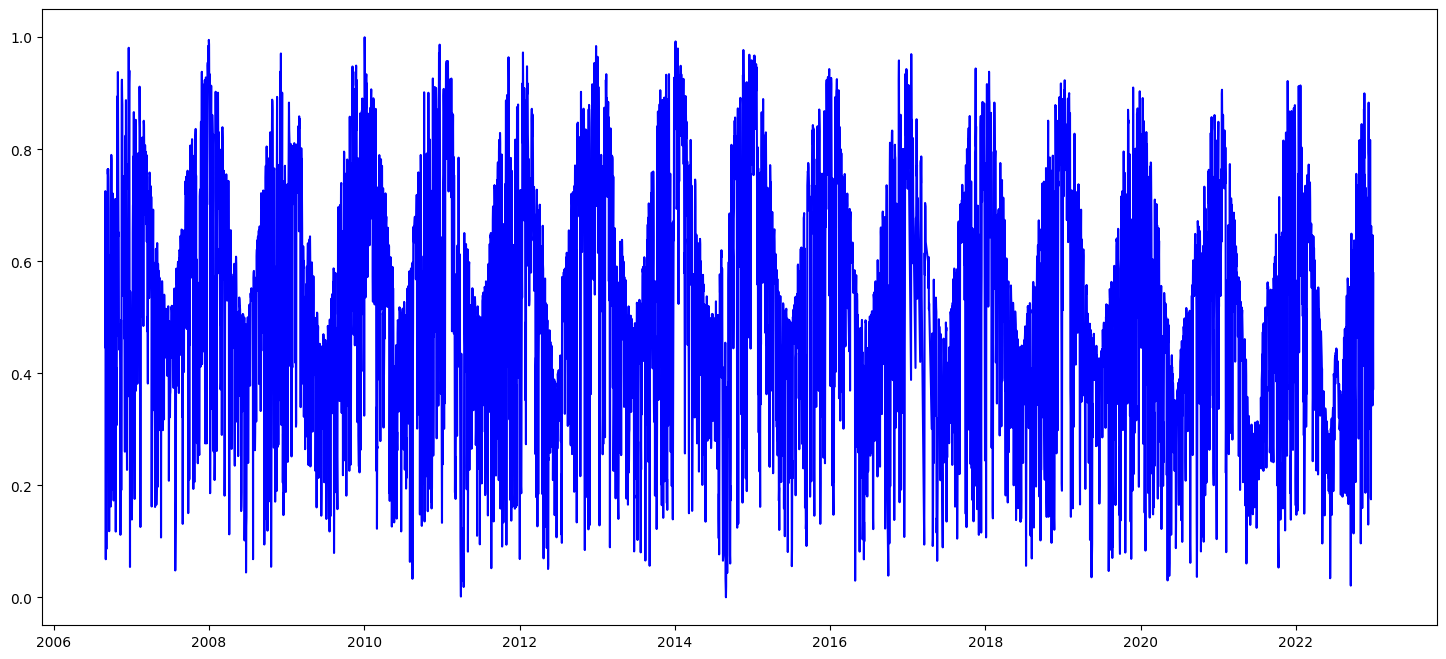

In [7]:
pyplot.figure(figsize=(18,8))

pyplot.plot(df['RADIATION'], color='blue', label='Radiation')

pyplot.show()

In [8]:
X, Y = windowing(df, predict_column='RADIATION', step_back=5, step_front=1)
x_train, y_train, x_test, y_test = split_data(X, Y, length=len(df), ratio=0.9)

In [9]:
print('x', x_train[0])
print('y', y_train[0])

x [[0.44661455 0.28006622 0.36673114]
 [0.72525503 0.17929363 0.45531915]
 [0.65086322 0.23978083 0.47781155]
 [0.0678993  0.26796484 0.62370821]
 [0.5230459  0.42709606 0.49604863]]
y 0.45072035143002115


In [10]:
print(x_train.shape)
print(y_train.shape)

(5371, 5, 3)
(5371,)


In [11]:
def objective(trial):
    n_hidden = trial.suggest_categorical(f"hidden_layers", [0, 1, 2, 3, 5])

    model = keras.Sequential()
    model.add(Dense(units=1, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(
        units=trial.suggest_categorical("lstm_01_unit", [10, 32, 64, 128, 200, 300]),
        return_sequences = n_hidden > 0
        ))
    
    if (trial.suggest_int("enable_dropout_01", 0, 1) == 1):
        model.add(Dropout(
            rate=trial.suggest_categorical("dropout_01_rs", [0, 0.1, 0.25])
        ))

    for i in range(n_hidden):
        model.add(LSTM(
            units=trial.suggest_categorical(f"lstm_{i}_unit", [10, 32, 64, 128, 200, 300]),
            return_sequences = i != (n_hidden-1),
            dropout=trial.suggest_categorical(f"lstm_{i}_drp", [0, 0.1, 0.25])
        ))

    model.add(layers.Dense(1, 
        activation=trial.suggest_categorical("output_activation", ['relu', 'softmax', 'sigmoid'])
    ))
    
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    
    model.compile(
        loss="mse",
        optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate),
        metrics=["accuracy"],
    )

    print('model output_shape', model.output_shape)

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    model.fit(
        x_train,
        y_train,
        validation_split=trial.suggest_categorical("validation_split", [0.1, 0.2, 0.3]),
        shuffle=True,
        batch_size=trial.suggest_categorical("batch_size", [10, 16, 32, 64]),
        epochs=100,
        verbose=0,
        callbacks=[es]
    )

    predict = model.predict(x_test)
    y = y_test.reshape(-1,1)
    
    print('Max Y', max(y_test))
    print('Min Y', min(y_test))
    print('Max Pred', max(predict))
    print('Min Pred', min(predict))
    
    mae = mean_absolute_error(y, predict)
    print('MAE SCORE:', mae)
    return mae

In [12]:
n_trials = 100
run_study = False

study = optuna.create_study(
    direction='minimize',
    storage='sqlite:///radiation-forecast.db',
    study_name=f'{city}_interpolate_lstm',
    load_if_exists=True
)

if len(study.trials) < n_trials and run_study:
    study.optimize(
        objective, 
        n_trials=n_trials, 
        gc_after_trial=True,
        n_jobs=8
    )   

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-09-29 18:13:42,678] Using an existing study with name 'vicosa_interpolate_lstm' instead of creating a new one.


Number of finished trials: 103
Best trial:
  Value: 0.10547836359825317
  Params: 
    hidden_layers: 2
    lstm_01_unit: 128
    enable_dropout_01: 0
    lstm_0_unit: 64
    lstm_0_drp: 0.25
    lstm_1_unit: 128
    lstm_1_drp: 0.1
    output_activation: relu
    learning_rate: 0.0003101382898963278
    validation_split: 0.2
    batch_size: 16


2023-09-29 18:15:32.222271: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-29 18:15:32.775162: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-29 18:15:32.775240: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-29 18:15:32.777361: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-29 18:15:32.777450: I tensorflow/compile

model output_shape (None, 1)
Epoch 1/100


2023-09-29 18:16:00.812360: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


269/269 [==============================] - 26s 27ms/step - loss: 0.0605 - accuracy: 4.6555e-04 - val_loss: 0.0372 - val_accuracy: 0.0000e+00
Epoch 2/100
269/269 [==============================] - 5s 19ms/step - loss: 0.0381 - accuracy: 2.3277e-04 - val_loss: 0.0347 - val_accuracy: 0.0000e+00
Epoch 3/100
269/269 [==============================] - 6s 22ms/step - loss: 0.0371 - accuracy: 2.3277e-04 - val_loss: 0.0329 - val_accuracy: 0.0000e+00
Epoch 4/100
269/269 [==============================] - 5s 18ms/step - loss: 0.0359 - accuracy: 2.3277e-04 - val_loss: 0.0308 - val_accuracy: 0.0000e+00
Epoch 5/100
269/269 [==============================] - 5s 20ms/step - loss: 0.0335 - accuracy: 2.3277e-04 - val_loss: 0.0281 - val_accuracy: 0.0000e+00
Epoch 6/100
269/269 [==============================] - 5s 19ms/step - loss: 0.0311 - accuracy: 4.6555e-04 - val_loss: 0.0268 - val_accuracy: 0.0000e+00
Epoch 7/100
269/269 [==============================] - 5s 19ms/step - loss: 0.0300 - accuracy: 4.65

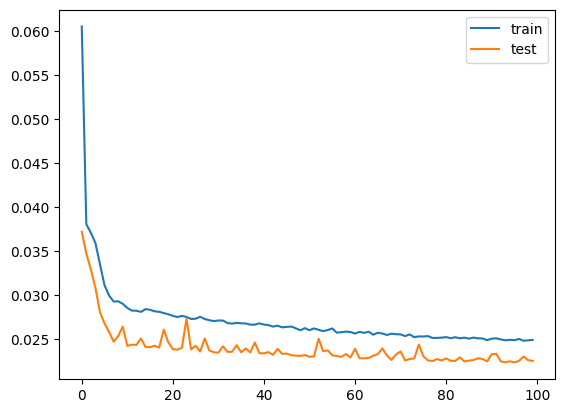

19/19 [==============================] - 1s 8ms/step


NameError: name 'show_error_metrics' is not defined

In [13]:
n_hidden = 2

model = keras.Sequential()
model.add(Dense(units=1, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(
    units=128,
    return_sequences = n_hidden > 0
    ))


# model.add(Dropout(
#     rate=0.1
# ))


model.add(LSTM(
    units=64,
    return_sequences = True,
    dropout=0.25
))

model.add(LSTM(
    units=128,
    return_sequences = False,
    dropout=0.1
))

# model.add(LSTM(
#     units=200,
#     return_sequences = False,
#     dropout=0
# ))

# model.add(LSTM(
#     units=64,
#     return_sequences = True,
#     dropout=0
# ))

# model.add(LSTM(
#     units=128,
#     return_sequences = False,
#     dropout=0
# ))

model.add(layers.Dense(1, 
    activation='relu'
))

learning_rate = 0.0003101382898963278

model.compile(
    loss="mse",
    optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate),
    metrics=["accuracy"],
)

print('model output_shape', model.output_shape)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    shuffle=True,
    batch_size=16,
    epochs=100,
    verbose=1,
    callbacks=[es]
)

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()





19/19 [==============================] - 0s 12ms/step
Test R2: 0.429
Test MSE: 0.021
Test RMSE: 0.144
Test MAE: 0.107
Test MAPE: 0.393


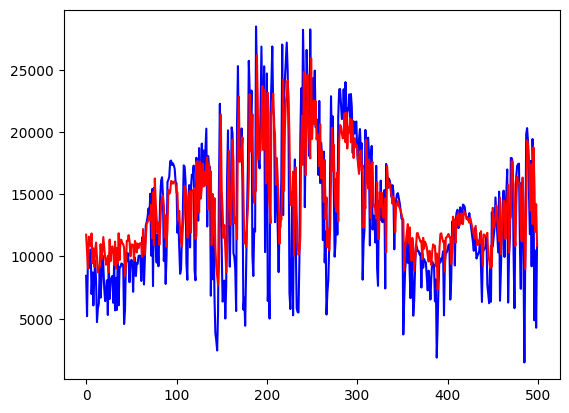

In [14]:
from src.dataframe import show_error_metrics

predict = model.predict(x_test)
show_error_metrics(y_test.reshape(-1,1), predict)

real = scaler.scales['RADIATION'].inverse_transform(y_test.reshape(-1,1))
predict = scaler.scales['RADIATION'].inverse_transform(predict)

range_plot = 500
pyplot.plot(real[0:range_plot], color='blue', label='real')
pyplot.plot(predict[0:range_plot], color='red', label='incompleto')

pyplot.show()